In [2]:
# !pip install corner
# !pip install emcee

In [223]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from PIL import Image

In [156]:
def gaussian(x, mu, sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * \
           np.exp(-(x - mu)**2 / (2 * sigma**2))

def gauss2d(image, xc, yc, sigma_x, sigma_y, flux):
    nrows, ncols = image.shape
    for y in range(nrows):
        for x in range(ncols):
            # image[y, x] += x * y
            # inpaint the distance from (xc, yc) of every pixel
            # dx = x - xc
            # dy = y - yc
            # image[y, x] = np.sqrt(dx**2 + dy**2)
            # image[y, x] = gaussian(dx, 0, sigma_x) * gaussian(dy, 0, sigma_y)
            image[y, x] = flux * gaussian(x, xc, sigma_x) * gaussian(y, yc, sigma_y)
    return image

def make_mask(image, xc, yc, radius):
    nrows, ncols = image.shape
    for y in range(nrows):
        for x in range(ncols):
            dx = x - xc
            dy = y - yc
            distance = np.sqrt(dx**2 + dy**2)
            if distance < radius:
                image[y, x] = 1
    return image

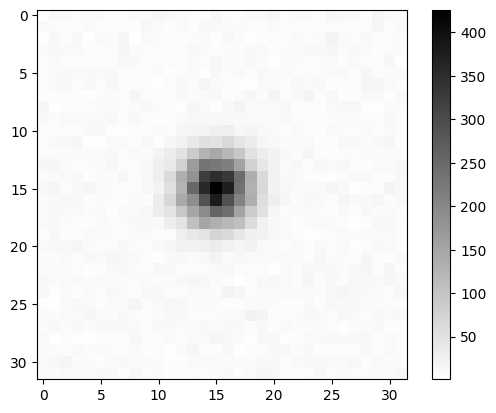

In [201]:
image = np.zeros((32, 32))

image = gauss2d(image, xc=15, yc=15, sigma_x=2, sigma_y=2, flux=10000)

image += 10

image_data = np.random.poisson(image)

plt.imshow(image_data, cmap='grey_r')
plt.colorbar()

3.2700793668132877
10.109215017064846
S/N = 3058.07985090919


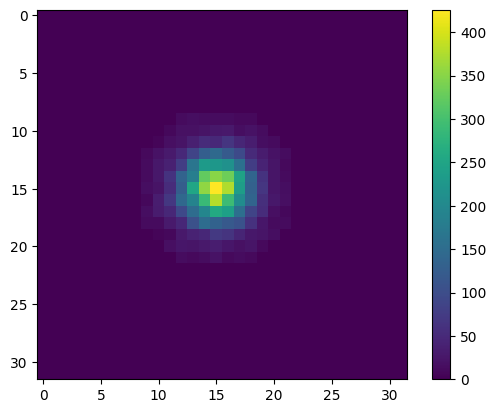

In [204]:
mask = np.zeros((32, 32))
mask = make_mask(mask, xc=15, yc=15, radius=3.5 * 2).astype(bool)

image_object = image_data.copy()
image_object[~mask] = 0

image_background = image_data.copy()
image_background[mask] = 0

# need to measure standard deviation of pixels outside the object
data_object = image_data[mask]
data_background = image_data[~mask]

sigma_background = np.std(data_background)
print(sigma_background)
mean_background = np.mean(data_background)
print(mean_background)

plt.imshow(image_object)
plt.colorbar();

flux_object_and_background = data_object.sum()
flux_background = mean_background * mask.sum() # len(data_object)

flux_object = flux_object_and_background - flux_background
flux_object

print(f'S/N = {flux_object / sigma_background}')

(100, 100, 3)


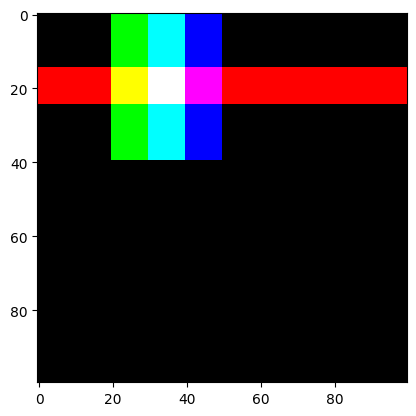

In [236]:
red = np.zeros((100, 100), dtype=np.uint8)
green = np.zeros_like(red)
blue = np.zeros_like(red)

red[15:25, :] = 255

green[0:40, 20:40] = 255

blue[0:40, 30:50] = 255

rgb = np.stack([red, green, blue], axis=2)

print(rgb.shape)

plt.imshow(rgb)

im = Image.fromarray(rgb)

In [237]:
im.save('test.png')

In [238]:
im = Image.open('test.png')

In [243]:
img = np.array(im)

img.shape
img.dtype

dtype('uint8')

In [248]:
# !wget https://static.wixstatic.com/media/9636a1_118c6908b67c43a8ae05de4889fd7729~mv2.jpg

In [253]:
im = Image.open('9636a1_118c6908b67c43a8ae05de4889fd7729~mv2.jpg')
img = np.array(im)

img.dtype
img.shape

(618, 700, 3)

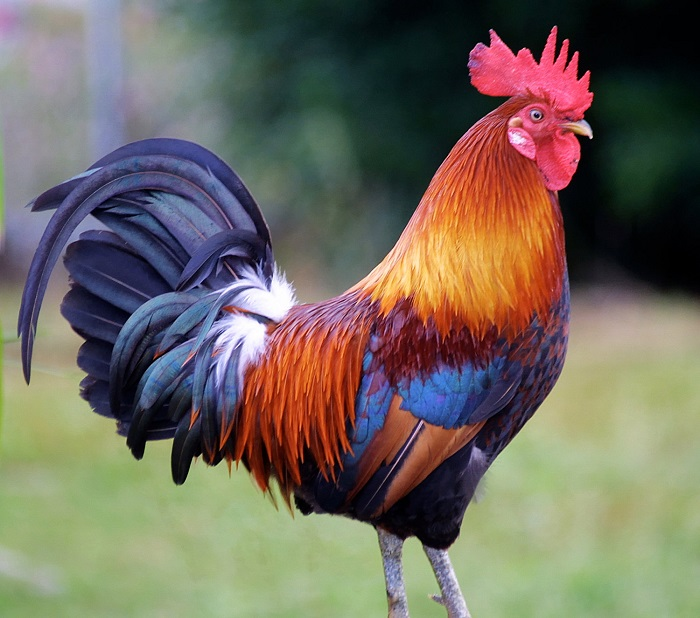

In [267]:
im

In [256]:
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

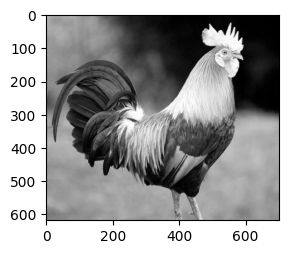

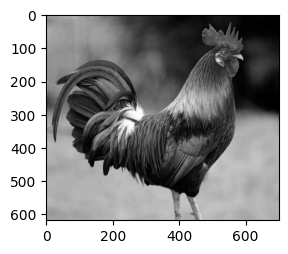

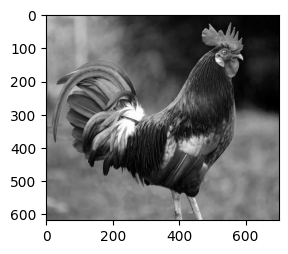

In [266]:
plt.figure(figsize=(3, 3))
plt.imshow(red, cmap='grey')
plt.show()
plt.figure(figsize=(3, 3))
plt.imshow(green, cmap='grey')
plt.show()
plt.figure(figsize=(3, 3))
plt.imshow(blue, cmap='grey')
plt.show()

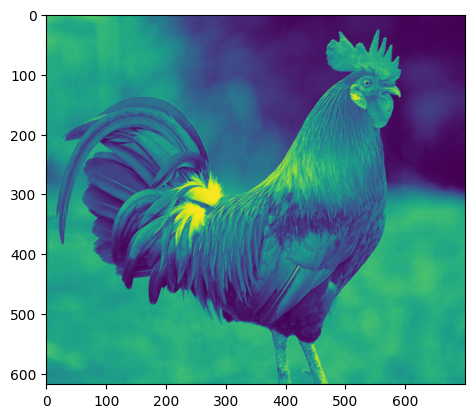

In [275]:
bird_sum = red.astype(float) + green.astype(float) + blue.astype(float)

plt.imshow(bird_sum)

In [165]:
x = np.array([1, 2, 3, 4, 5])

y = np.array([0, 0, 1, 1, 0]).astype(bool)

# x[0:3].sum()

x[y]

array([3, 4])

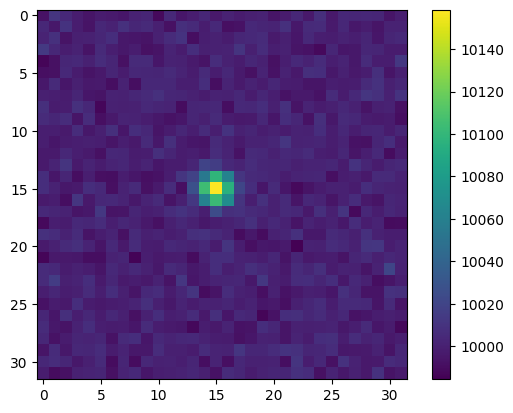

In [158]:
image_list = []

for observation in range(400):
    image = np.zeros((32, 32))
    image = gauss2d(image, xc=15, yc=15, sigma_x=1, sigma_y=1, flux=1000)
    image += 10000
    image_data = np.random.poisson(image)
    image_list.append(deepcopy(image_data))

images = np.stack(image_list)

image = np.mean(images, axis=0)

plt.imshow(image)
plt.colorbar()

In [ ]:
plt.imshow(np.log10(image - 9990), cmap='grey_r');
plt.colorbar();

In [107]:
image.sum()

np.float64(10000.000107011523)

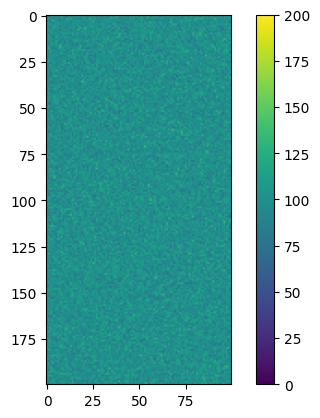

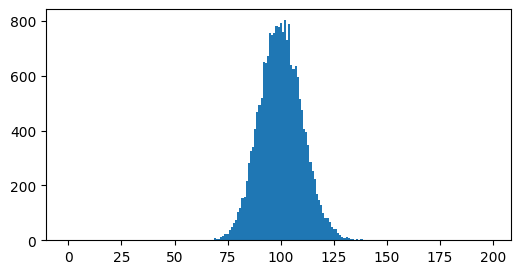

In [48]:
image = np.zeros((200, 100))

background = 100

image += background

image_data = np.random.poisson(image)

plt.imshow(image_data, vmin=0, vmax=background+100)
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 3))
plt.hist(image_data.ravel(), bins=np.arange(200) - 0.5);

# from histogram FWHM = 2.35 * sigma
# 25 / 2.35 ~ 11
# from poisson distr. mean 100 -> sigma = sqrt(100) = 10
# 11 ~ 10

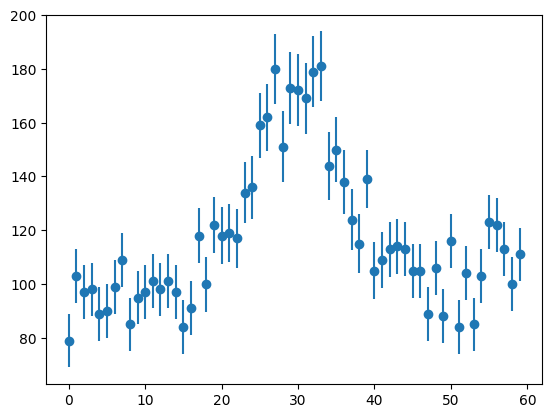

In [ ]:
def model(x, params):
    mu, sigma, flux, background = params
    y = flux * gaussian(x, mu, sigma) + background
    return y

def generate_data(params):
    num_pixels = 60
    x = np.arange(0, num_pixels)
    y = model(x, params)
    sigma_err_list = np.sqrt(y)   # if flux is [counts] assuming poisson noise
    # add readout noise
    sigma_readout = 0
    s2 = sigma_err_list**2 + sigma_readout**2
    sigma_err_list = np.sqrt(s2)
    # for low signals
    y_data = np.random.poisson(y) + np.random.normal(0, sigma_readout, num_pixels)
    return x, y_data, sigma_err_list

MU_TRUE = 30
SIGMA_TRUE = 5  # well sampled   FWHM = 3 = 2.35 sigma
FLUX_TRUE = 1000   # [counts] not [counts / s]
BACKGROUND_TRUE = 100
PARAMS_TRUE = [MU_TRUE, SIGMA_TRUE, FLUX_TRUE, BACKGROUND_TRUE]

x_list, y_data_list, sigma_list = \
    generate_data(PARAMS_TRUE)

plt.errorbar(x_list, y_data_list, yerr=sigma_list, fmt='o');

In [ ]:
def log_prior(pars):
    mu, sigma, flux, background = pars
    if 0 < mu < 60 and 0 < sigma and 0 < flux and 0 < background:
        return 0
    return -np.inf

In [ ]:
def log_prob(pars, x_list, y_data_list, sigma_list):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf
    y_model_list = model(x_list, pars)
    log_likelihood = 0
    for y_data, y_model, sigma in zip(y_data_list, y_model_list, sigma_list):
        likelihood = gaussian(y_data, y_model, sigma)
        log_likelihood += np.log(likelihood)
    return lp + log_likelihood

pars_initial = np.array([30, 5, 1000, 100])

ndim = len(pars_initial)
nwalkers = 2 * ndim

start_pos = pars_initial + np.random.normal(0, 1e-5, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[x_list, y_data_list, sigma_list])
res = sampler.run_mcmc(start_pos, 3000)

In [ ]:
samples = sampler.get_chain(flat=True)
samples.shape

(24000, 4)

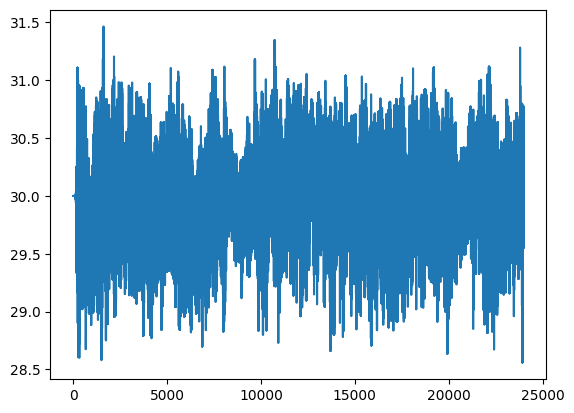

In [ ]:
plt.plot(samples[:, 0]);

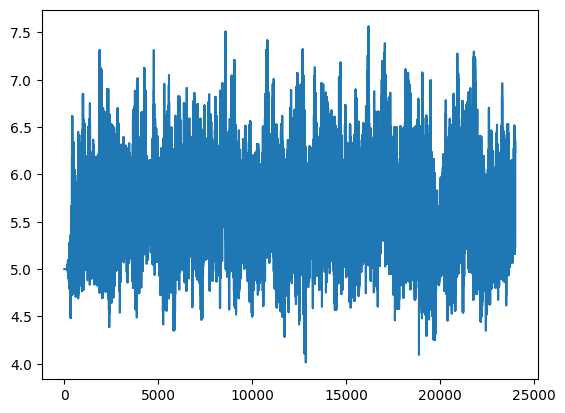

In [ ]:
plt.plot(samples[:, 1]);

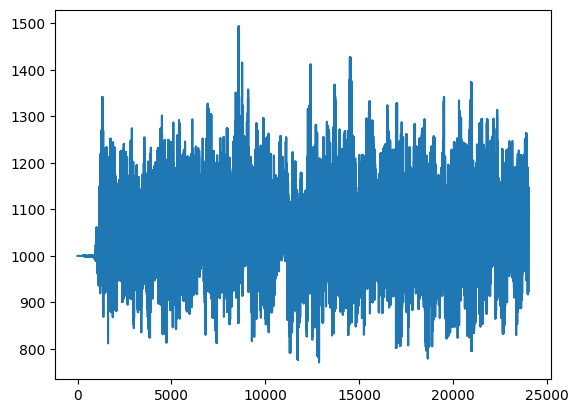

In [ ]:
plt.plot(samples[:, 2]);

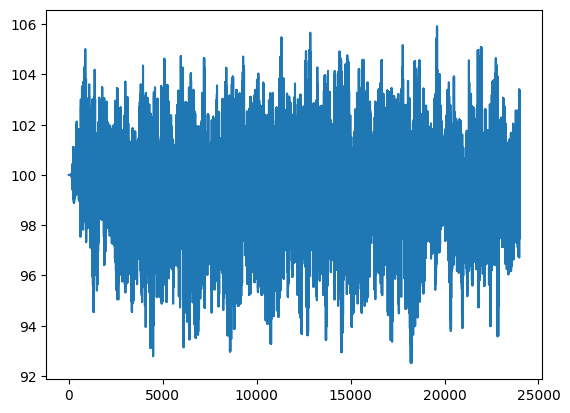

In [ ]:
plt.plot(samples[:, 3]);

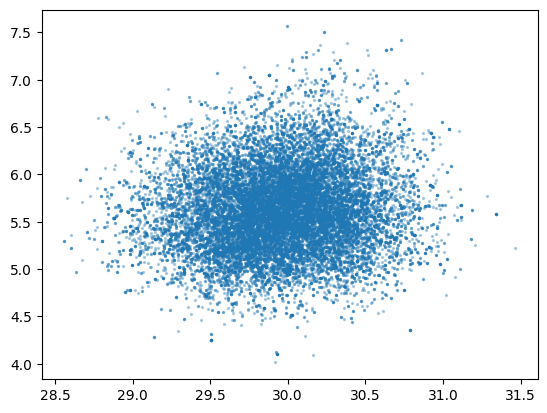

In [ ]:
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.3);

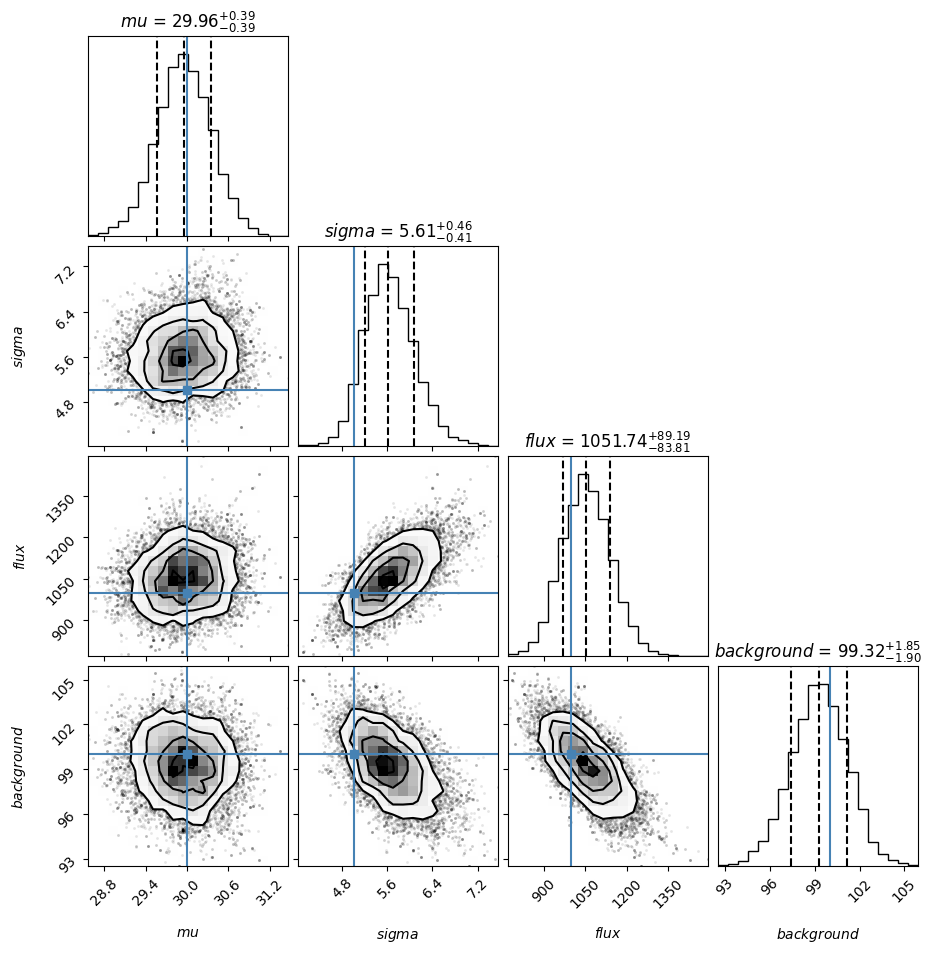

In [ ]:
figure = corner.corner(
    samples[1000:],
    labels=[
        r"$mu$",
        r"$sigma$",
        r"$flux$",
        r"$background$",
    ],
    truths=PARAMS_TRUE,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

In [ ]:
# 20    - 0.075
# 200   - 0.02

# np.sqrt(200/20) * 0.02

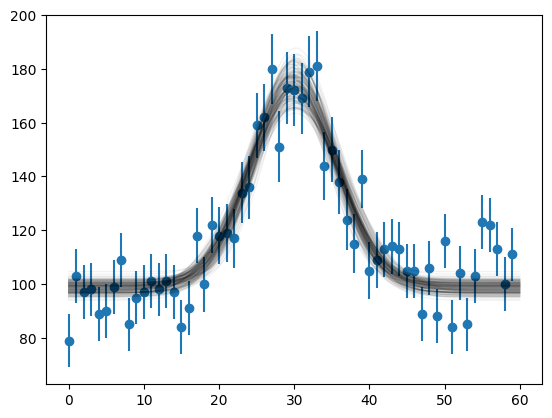

In [ ]:
x_list_model = np.linspace(0, 60, 1000)
for mu, sigma, flux, background in samples[1000:17000:100]:
    y_model = model(x_list_model, [mu, sigma, flux, background])
    plt.plot(x_list_model, y_model, c='k', alpha=0.05, lw=1, zorder=2)
plt.errorbar(x_list, y_data_list, yerr=sigma_list, fmt='o', zorder=1);